# Dog Breed Prediction using Trasnfer Learing on SageMaker

**This notebook walks through implementation of Image Classification Machine Learning Model to classify between 133 kinds of dog breeds using dog breed dataset provided by Udacity (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)**

- We will be using a pretrained Resnet50 model from pytorch vision library (https://pytorch.org/vision/master/generated/torchvision.models.resnet50.html)
- We will be adding in two Fully connected Neural network Layers on top of the above Resnet50 model.
- Note: We will be using concepts of Transfer learning and so we will be freezing all the exisiting Convolutional layers in the pretrained resnet50 model and only changing gradients for the tow fully connected layers that we have added.
- Then we will perform Hyperparameter tuning, to help figure out the best hyperparameters to be used for our model.
- Next we will be using the best hyperparameters and fine-tuning our Resent50 model.
- We will also be adding in configuration for Profiling and Debugging our training mode by adding in relevant hooks in the Training and Testing( Evaluation) phases.
- Next we will be deploying our model. While deploying we will create our custom inference script. The custom inference script will be overriding a few functions that will be used by our deployed endpoint for making inferences/predictions.
- Finally we will be testing out our model with some test images of dogs, to verfiy if the model is working as per our expectations.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.3 MB/s eta 0:00:00
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6415 sha256=519c245eddbca9b9c9c228d306d6d31c02c9c27666f5fd96943a76b21eda4ef1
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.12
    Uninstalling protobuf-4.21.12:
      Successfully uninstalled protobuf-4.21.12


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region us-east-1
Default s3 bucket : sagemaker-us-east-1-683750140738


## Dataset
The dataset we used for this project is the dogImages dataset that can be found in this [link](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). It contains images of 133 dog breed split into train, valid and test folders each containing a sample of every breed. An example from the train folder s is ****./dogImages/test/018.Beauceron/Beauceron_01284.jpg****

In [3]:
#TODO: Fetch and upload the data to AWS S3

!wget --no-check-certificate https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip  > /dev/null

--2024-05-02 22:15:02--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.48, 52.219.112.56, 52.219.194.136, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.48|:443... connected.
ERROR: cannot verify s3-us-west-1.amazonaws.com's certificate, issued by ‘CN=Amazon RSA 2048 M01,O=Amazon,C=US’:
  Unable to locally verify the issuer's authority.
To connect to s3-us-west-1.amazonaws.com insecurely, use `--no-check-certificate'.
unzip:  cannot find or open dogImages.zip, dogImages.zip.zip or dogImages.zip.ZIP.


In [ ]:
prefix ="dogImages"
print("Starting to upload dogImages")

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")

Starting to upload dogImages


In [5]:
inputs = 's3://sagemaker-us-east-1-683750140738/dogImages/'
print(f"Input path ( S3 file path ): {inputs}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-683750140738/dogImages/


## Hyperparameter Tuning

The ResNet50 model with a two Fully connected Linear NN layer's is used for this image classification problem. ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. Furthermore the model has a lot of trainable parameters, which indicates a deep architecture that makes it better for image recognition
The optimizer that we will be using for this model is AdamW ( For more info refer : https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html )
Hence, the hyperparameters selected for tuning were:
Learning rate - default(x) is 0.001 , so we have selected 0.01x to 100x range for the learing rate
eps - defaut is 1e-08 , which is acceptable in most cases so we have selected a range of 1e-09 to 1e-08
Weight decay - default(x) is 0.01 , so we have selected 0.1x to 10x range for the weight decay
Batch size -- selected only two values [ 64, 128 ]

In [6]:
#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay and eps hyperparamter tuning as well , along with the lerning rate and batchsize params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [8]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................................................................................................................................................................!


In [9]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-05-02 22:39:20 Starting - Found matching resource for reuse
2024-05-02 22:39:20 Downloading - Downloading the training image
2024-05-02 22:39:20 Training - Training image download completed. Training in progress.
2024-05-02 22:39:20 Uploading - Uploading generated training model
2024-05-02 22:39:20 Completed - Resource reused by training job: pytorch-training-240502-2218-004-f59e5c79


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '3.0508485734923653e-09',
 'lr': '0.0002466403764881313',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-05-02-22-18-04-089"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-683750140738/dog-breed-classification-hpo-2024-05-02-22-18-04-089/source/sourcedir.tar.gz"',
 'weight_decay': '0.09930414190565788'}

In [10]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '3.0508485734923653e-09', 'lr': '0.0002466403764881313', 'weight_decay': '0.09930414190565788'}


## Model Profiling and Debugging

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [12]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-05-02-23-02-15-173


2024-05-02 23:02:16 Starting - Starting the training job...
2024-05-02 23:02:45 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-05-02 23:03:09 Downloading - Downloading input data......
2024-05-02 23:04:14 Downloading - Downloading the training image......
2024-05-02 23:05:08 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-05-02 23:05:18,616 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-05-02 23:05:18,655 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-05-02 23:05:18,658 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-05-02 23:05:18,966 sagemaker-training-toolkit INFO     Invokin

In [13]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [14]:
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2024-05-02-23-02-15-173
Client: <botocore.client.SageMaker object at 0x7f61f5e6fa30>
Description: {'TrainingJobName': 'pytorch-training-2024-05-02-23-02-15-173', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:683750140738:training-job/pytorch-training-2024-05-02-23-02-15-173', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"3.0508485734923653e-09"', 'lr': '"0.0002466403764881313"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2024-05-02-23-02-15-173"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/source/sourcedir.tar.gz"', 'weight_decay': '"0.09930414190565788"'}, 'AlgorithmSpecif

In [15]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-05-02 23:23:52.077 default:230 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-05-02 23:23:52.092 default:230 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/debug-output


In [16]:
trial.tensor_names() #all the tensor names

[2024-05-02 23:23:54.573 default:230 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-05-02 23:23:55.590 default:230 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [17]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

11

In [18]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

14

In [19]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

INFO:matplotlib.font_manager:generated new fontManager


loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


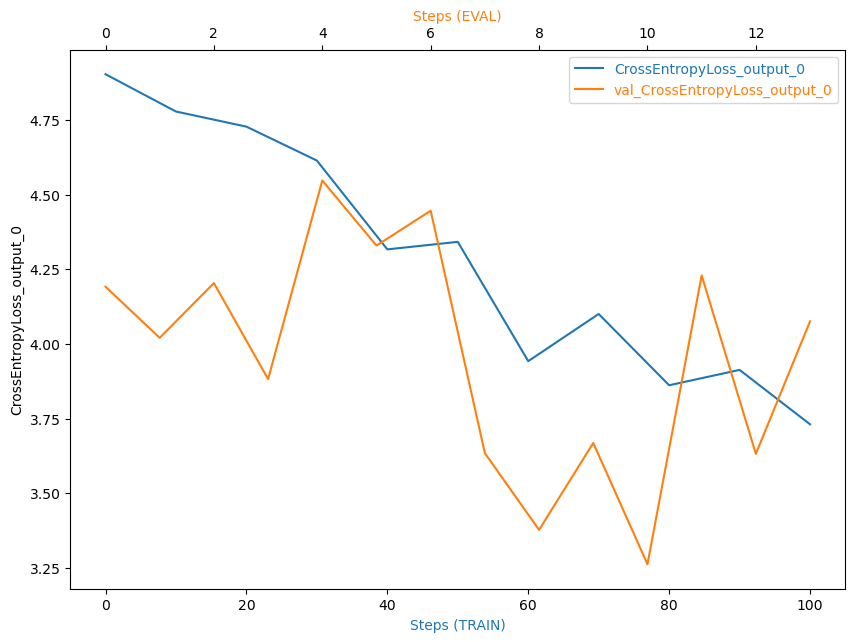

In [20]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [21]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/rule-output


In [22]:
! aws s3 ls {rule_output_path} --recursive

2024-05-02 23:11:28     381872 pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-05-02 23:11:28     231053 pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-05-02 23:11:23        191 pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-05-02 23:11:23      17658 pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-05-02 23:11:23        126 pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-05-02 23:11:23        129 pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-05-02 23:11:23       2754 pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-re

In [23]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-683750140738/pytorc

In [24]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [25]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [26]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/home/sagemaker-user/dog/Image_Classification_using_AWS_SageMaker/profiler_report.zip'

## Model Deploying

In [54]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-02-23-02-15-173/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-03-00-17-57-551/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-training-2024-05-03-00-17-57-551
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2024-05-03-00-17-57-551
INFO:sagemaker:Creating endpoint with name pytorch-training-2024-05-03-00-17-57-551


------!

In [57]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-03-00-17-57-551/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium") #Using ml.t2.medium to save costs

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-683750140738/pytorch-training-2024-05-03-00-17-57-551/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-683750140738/pytorch-inference-2024-05-03-00-24-16-311/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-05-03-00-24-27-574
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-05-03-00-24-28-331
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-05-03-00-24-28-331


-------------!

Test image no: 1
Below is the image that we will be testing:


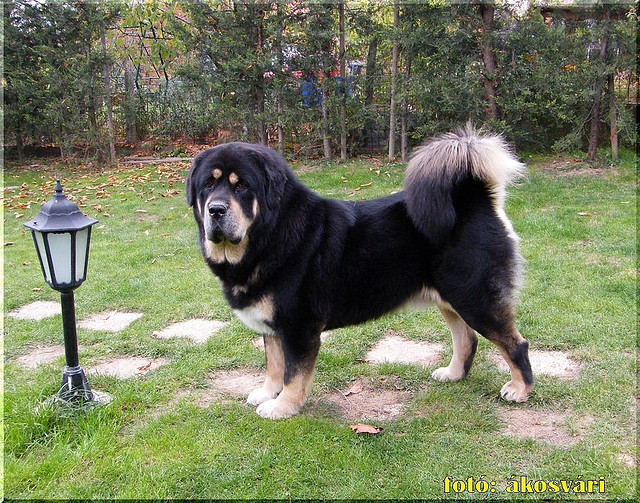

Expected dog breed category no : 51
Response: [[0.15225502848625183, 0.0, 0.20849348604679108, 1.6842859983444214, 0.0, 1.158460021018982, 0.364339143037796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0829665660858154, 0.0, 0.0, 0.0, 0.0, 0.8247653841972351, 1.3644567728042603, 0.0, 0.0, 0.0, 0.26193708181381226, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06573903560638428, 0.0, 0.0, 2.0375828742980957, 0.0, 0.7129938006401062, 0.9872007966041565, 0.0, 0.37968525290489197, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43691080808639526, 0.4810229241847992, 0.438294380903244, 0.0, 0.0, 0.0, 0.18140459060668945, 0.8121432065963745, 0.0, 0.7341600060462952, 0.0, 0.0, 0.8397150039672852, 0.9480684399604797, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47840434312820435, 0.5797771215438843, 0.0, 0.0, 1.154227614402771, 1.1453368663787842, 0.3193035423755646, 0.0, 0.0, 0.05698224529623985, 0.0, 0.0, 0.

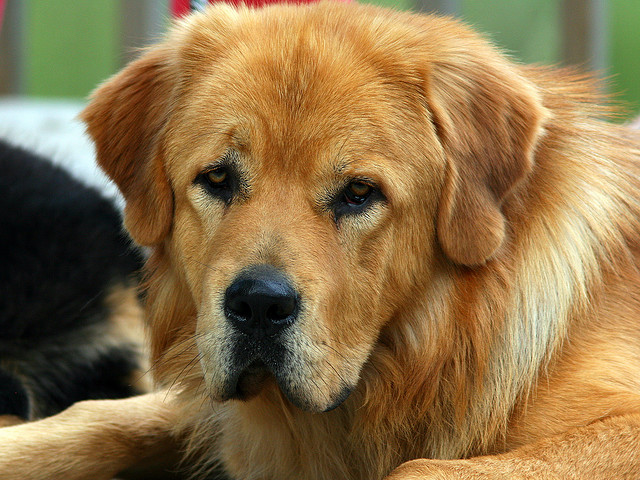

Expected dog breed category no : 5
Response: [[0.0, 0.0, 0.8336689472198486, 1.5175039768218994, 0.0, 0.2773679196834564, 1.0753138065338135, 0.0, 0.0, 0.04174615442752838, 0.0, 0.0, 0.0, 0.0, 0.3021255135536194, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2692540884017944, 1.263205647468567, 0.0, 0.0, 0.0, 1.2272316217422485, 0.0, 0.0, 0.5969026684761047, 0.0, 0.0, 0.21324332058429718, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19568048417568207, 0.0, 0.0, 0.0, 0.0, 0.819330096244812, 0.0, 0.0, 0.0, 3.0402984619140625, 0.0, 0.34756574034690857, 1.0347442626953125, 0.1398778259754181, 0.3664219081401825, 0.0, 0.0, 0.0, 0.0, 0.24449323117733002, 0.0, 0.0, 0.0, 0.26045843958854675, 0.4387594163417816, 0.0, 0.0, 0.0, 0.0, 1.194606065750122, 0.0, 1.4353721141815186, 0.0, 0.0, 3.366309642791748, 0.2614162862300873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9190072417259216, 0.0, 0.0, 2.2045249938964844, 0.4744618237018585, 0.0, 0.0, 0.0, 0.7885658740997314, 0

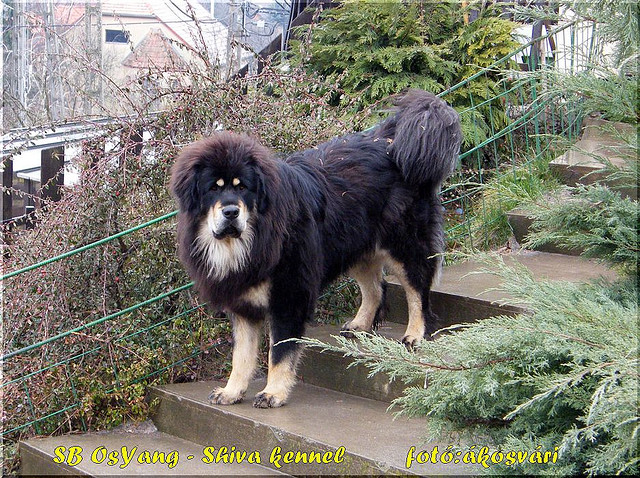

Expected dog breed category no : 21
Response: [[0.8827840089797974, 0.0, 0.810055673122406, 1.2990350723266602, 0.0, 0.44726046919822693, 0.0, 0.0, 0.0, 0.2683168947696686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6095168590545654, 0.0, 0.0, 0.0, 0.0, 1.1403900384902954, 1.362725853919983, 0.0, 0.0, 0.0, 0.09514603763818741, 0.0, 0.0, 0.2697824537754059, 0.0, 0.0, 1.0659596920013428, 0.0, 0.1827263981103897, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20590130984783173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1445233821868896, 0.0, 0.34569260478019714, 1.2454735040664673, 0.2790025472640991, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.467572420835495, 0.0, 0.8148319721221924, 0.0, 0.0, 0.0, 0.0, 0.7635743021965027, 0.0, 1.1895939111709595, 0.0, 0.0, 0.4768115282058716, 0.3192541003227234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.182094693183899, 0.018120743334293365, 0.0, 0.0, 1.777174472808838, 1.3092772960662842, 0.7945849895477295, 0.0, 0.0, 0.4243682324886322, 0

In [65]:
#Testing the deployed endpoint using some test images
#Solution 1: Using the Predictor object directly.
from PIL import Image
import io
import os
import numpy as np

test_dir = "./test_images/"
test_images = ["Tibetan_mastiff_08140.jpg", "Tibetan_mastiff_08139.jpg", "Tibetan_mastiff_08138.jpg"]
test_images_expected_output = [51, 5, 21]
for index in range(len(test_images)):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")
        print("----------------------------------------------------------------------")

In [62]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2024-05-03-00-24-28-331


Test image no: 1
Below is the image that we will be testing:


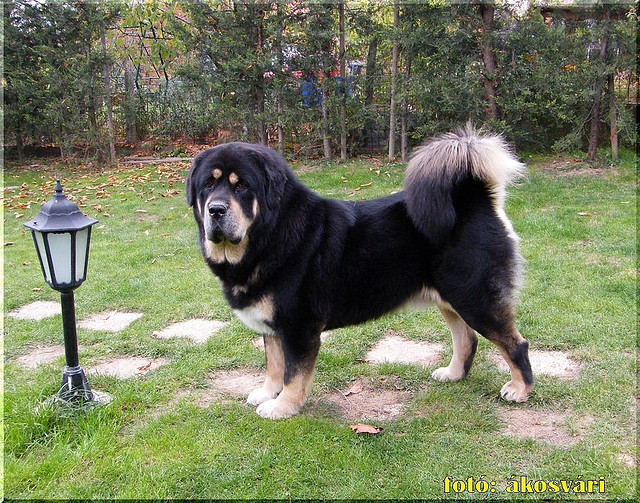

Expected dog breed category no : 151
Response: [[0.15225503 0.         0.20849349 1.684286   0.         1.15846002
  0.36433914 0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.08296657 0.
  0.         0.         0.         0.82476538 1.36445677 0.
  0.         0.         0.26193708 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.06573904
  0.         0.         2.03758287 0.         0.7129938  0.9872008
  0.         0.37968525 0.         0.         0.         0.
  0.         0.         0.         0.43691081 0.48102292 0.43829438
  0.         0.         0.         0.18140459 0.81214321 0.
  0.73416001 0.         0.         0.839715   0.94806844 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.       

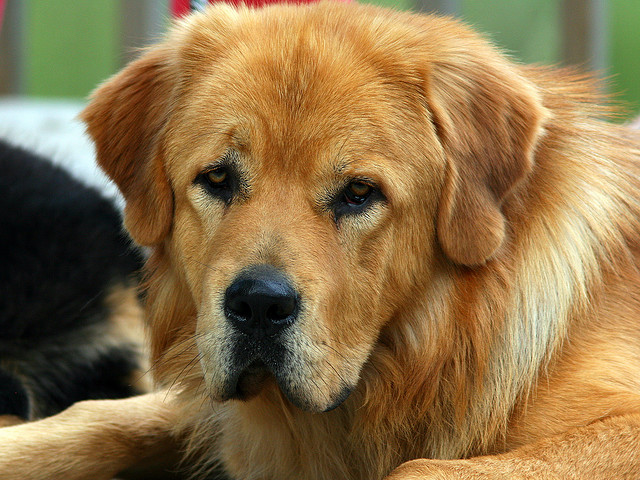

Expected dog breed category no : 5
Response: [[0.         0.         0.83366895 1.51750398 0.         0.27736792
  1.07531381 0.         0.         0.04174615 0.         0.
  0.         0.         0.30212551 0.         0.         0.
  0.         0.         0.         1.26925409 1.26320565 0.
  0.         0.         1.22723162 0.         0.         0.59690267
  0.         0.         0.21324332 0.         0.         0.
  0.         0.         0.         0.         0.         0.19568048
  0.         0.         0.         0.         0.8193301  0.
  0.         0.         3.04029846 0.         0.34756574 1.03474426
  0.13987783 0.36642191 0.         0.         0.         0.
  0.24449323 0.         0.         0.         0.26045844 0.43875942
  0.         0.         0.         0.         1.19460607 0.
  1.43537211 0.         0.         3.36630964 0.26141629 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.

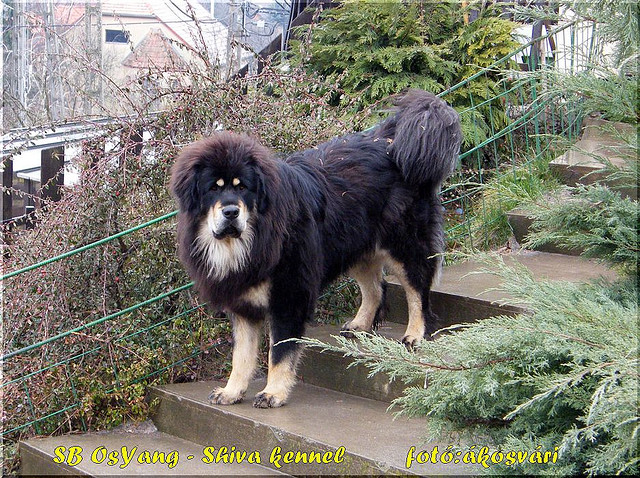

Expected dog breed category no : 21
Response: [[0.88278401 0.         0.81005567 1.29903507 0.         0.44726047
  0.         0.         0.         0.26831689 0.         0.
  0.         0.         0.         0.         1.60951686 0.
  0.         0.         0.         1.14039004 1.36272585 0.
  0.         0.         0.09514604 0.         0.         0.26978245
  0.         0.         1.06595969 0.         0.1827264  0.
  0.         0.         0.         0.         0.         0.20590131
  0.         0.         0.         0.         0.         0.
  0.         0.         2.14452338 0.         0.3456926  1.2454735
  0.27900255 0.         0.         0.         0.         0.
  0.         0.         0.         0.46757242 0.         0.81483197
  0.         0.         0.         0.         0.7635743  0.
  1.18959391 0.         0.         0.47681153 0.3192541  0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.

In [67]:
# Solution 2: Using boto3
# Using the runtime boto3 client to test the deployed models endpoint
import os
import io
import boto3
import json
import base64
import PIL
# setting the  environment variables

ENDPOINT_NAME = endpoint_name
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_dir = "./test_images/"
test_images = ["Tibetan_mastiff_08140.jpg", "Tibetan_mastiff_08139.jpg", "Tibetan_mastiff_08138.jpg"]
test_images_expected_output = [151, 5, 21 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

#### From the above test images we can see that from the 3 test images, model was able to correctly predict the breed of the first image.

In [68]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-05-03-00-24-28-331
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-05-03-00-24-28-331
